# __Cleaning the Data Scraped from Craigslist Rental Listings__
### W. W. Supplee 2020

In [1]:
#!/usr/bin/python3

import getLivedata as gl
import visualizeData as cl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import re
%matplotlib inline

In [2]:
df = gl.getDataFromDisk('data.h5')

In [3]:
df.head()

,pid,date,neighborhood,title,bedrooms,bathrooms,sqft,url,price,attributes,latitude,longitude
7091649847,7091649847,2020-03-11,Mountain View,"2br - 2/1, Park, Nature trail, Google access (...",2,1,950,https://sfbay.craigslist.org/pen/apa/d/mountai...,3020,applicat|apartmen|laundryi|nosmokin|carport|,37.395954,-122.067890
7091643626,7091643626,2020-03-11,Daly City,Updated Condo close to Serramonte shopping center,1,1,717,https://sfbay.craigslist.org/pen/apa/d/daly-ci...,1705,catsareo|dogsareo|furnishe|condo|w/dinuni|nosm...,37.664634,-122.463684
7091648589,7091648589,2020-03-11,San Mateo,3 Bedroom 3 Bath Condo Style Home (w/ Fireplac...,3,3,1425,https://sfbay.craigslist.org/pen/apa/d/san-mat...,5180,evchargi|applicat|catsareo|dogsareo|apartmen|w...,37.562354,-122.285813
7091647413,7091647413,2020-03-11,San Mateo,Spacious 1st Floor 1Bed/1Bath w/ Hardwood Floo...,1,1,807,https://sfbay.craigslist.org/pen/apa/d/san-mat...,3330,applicat|dogsareo|apartmen|w/dinuni|nosmokin|a...,37.558650,-122.285651
7091646440,7091646440,2020-03-11,San Mateo,Newly renovated 1st Floor 1Bed/1Bath w/ Hardwo...,1,1,807,https://sfbay.craigslist.org/pen/apa/d/san-mat...,3255,evchargi|applicat|catsareo|dogsareo|apartmen|w...,37.558650,-122.285651


In [4]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 32)
df.describe()

,pid,bedrooms,bathrooms,sqft,price
count,1.655000e+03,1655.000000,1655.000000,1655.000000,1655.000000
mean,7.089939e+09,1.480363,1.280363,729.715408,3370.365559
std,4.109214e+06,0.887612,0.557412,484.341014,1128.903848
min,7.072154e+09,0.000000,0.000000,-1.000000,510.000000
25%,7.089440e+09,1.000000,1.000000,540.000000,2625.000000
50%,7.091459e+09,1.000000,1.000000,740.000000,3199.000000
75%,7.092198e+09,2.000000,2.000000,984.500000,3857.000000
max,7.093485e+09,6.000000,5.000000,4348.000000,12500.000000


__While we're working to clean the data, let's work with a temporary copy of the dataframe:__

In [5]:
tf = df.copy()
tf.neighborhood.describe()

count              1655
unique               24
top       Mountain View
freq                289
Name: neighborhood, dtype: object

In [6]:
tf.neighborhood.value_counts()

Mountain View             289
San Mateo                 237
Redwood City              201
Palo Alto                 186
Daly City                 148
Foster City               132
Menlo Park                 90
Pacifica                   67
Burlingame                 61
San Bruno                  61
South San Francisco        57
Belmont                    36
Millbrae                   25
San Carlos                 19
Los Altos                  18
East Palo Alto              9
Half Moon Bay               8
Brisbane                    3
Downtown Mountain View      2
Atherton                    2
Daly City, Ca               1
Coastside/Pescadero         1
Portola Valley              1
Woodside                    1
Name: neighborhood, dtype: int64

__We can see already that some posts are either not on the peninsula (i.e. posted on the wrong forum) or otherwise outliers.  We will remove any category with <5 observations__    

In [7]:
byNeighborhood = tf.groupby('neighborhood')
outlier_index = byNeighborhood.filter(lambda x : len(x)<5).index
tf=tf.drop(outlier_index)
tf.neighborhood.value_counts()

Mountain View          289
San Mateo              237
Redwood City           201
Palo Alto              186
Daly City              148
Foster City            132
Menlo Park              90
Pacifica                67
San Bruno               61
Burlingame              61
South San Francisco     57
Belmont                 36
Millbrae                25
San Carlos              19
Los Altos               18
East Palo Alto           9
Half Moon Bay            8
Name: neighborhood, dtype: int64

In [8]:
tf.groupby('neighborhood').describe()

pid                                            \
                     count          mean           std           min   
neighborhood                                                           
Belmont               36.0  7.090857e+09  3.811207e+06  7.073958e+09   
Burlingame            61.0  7.089479e+09  5.334344e+06  7.074058e+09   
Daly City            148.0  7.088091e+09  5.031685e+06  7.073035e+09   
East Palo Alto         9.0  7.092286e+09  1.500879e+06  7.088531e+09   
Foster City          132.0  7.090716e+09  3.455298e+06  7.073444e+09   
Half Moon Bay          8.0  7.086632e+09  4.920494e+06  7.079177e+09   
Los Altos             18.0  7.086132e+09  6.128765e+06  7.073907e+09   
Menlo Park            90.0  7.090021e+09  3.708285e+06  7.078649e+09   
Millbrae              25.0  7.089892e+09  4.238743e+06  7.074023e+09   
Mountain View        289.0  7.090257e+09  3.843997e+06  7.073402e+09   
Pacifica              67.0  7.089087e+09  4.454492e+06  7.074153e+09   
Palo Alto            186.0  7.090213e+09  3.648871e+06  7.072154e+09   
Redwood City         201.0  7.090386e+09  3.980252e+06  7.073939e+09   
San Bruno             61.0  7.090065e+09  3.729007e+06  7.074124e+09   
San Carlos            19.0  7.091262e+09  2.590494e+06  7.081046e+09   
San Mateo            237.0  7.089877e+09  4.107030e+06  7.072203e+09   
South San Francisco   57.0  7.090635e+09  2.458485e+06  7.082804e+09   

                                                                             \
                              25%           50%           75%           max   
neighborhood                                                                  
Belmont              7.091019e+09  7.091742e+09  7.092316e+09  7.093455e+09   
Burlingame           7.090193e+09  7.091596e+09  7.092349e+09  7.093485e+09   
Daly City            7.085420e+09  7.090492e+09  7.091581e+09  7.093449e+09   
East Palo Alto       7.092351e+09  7.092354e+09  7.093415e+09  7.093440e+09   
Foster City          7.090897e+09  7.091578e+09  7.092721e+09  7.093481e+09   
Half Moon Bay        7.083277e+09  7.087235e+09  7.089184e+09  7.093409e+09   
Los Altos            7.081296e+09  7.088480e+09  7.090842e+09  7.091789e+09   
Menlo Park           7.089453e+09  7.091243e+09  7.092165e+09  7.093484e+09   
Millbrae             7.088807e+09  7.091547e+09  7.092338e+09  7.093430e+09   
Mountain View        7.090546e+09  7.091488e+09  7.092303e+09  7.093485e+09   
Pacifica             7.088217e+09  7.090889e+09  7.091702e+09  7.093479e+09   
Palo Alto            7.089105e+09  7.091456e+09  7.092767e+09  7.093480e+09   
Redwood City         7.090914e+09  7.091567e+09  7.092731e+09  7.093467e+09   
San Bruno            7.090244e+09  7.091145e+09  7.092076e+09  7.093460e+09   
San Carlos           7.091226e+09  7.091878e+09  7.092323e+09  7.093357e+09   
San Mateo            7.089804e+09  7.091509e+09  7.092137e+09  7.093484e+09   
South San Francisco  7.090532e+09  7.091059e+09  7.092157e+09  7.093481e+09   

                    bedrooms                                               \
                       count      mean       std  min  25%  50%  75%  max   
neighborhood                                                                
Belmont                 36.0  1.222222  0.637455  0.0  1.0  1.0  2.0  3.0   
Burlingame              61.0  1.180328  0.806395  0.0  1.0  1.0  2.0  3.0   
Daly City              148.0  1.391892  0.923135  0.0  1.0  1.0  2.0  5.0   
East Palo Alto           9.0  0.777778  0.833333  0.0  0.0  1.0  1.0  2.0   
Foster City            132.0  1.393939  0.696311  0.0  1.0  1.0  2.0  4.0   
Half Moon Bay            8.0  1.125000  0.991031  0.0  0.0  1.5  2.0  2.0   
Los Altos               18.0  1.666667  1.084652  0.0  1.0  1.0  2.0  4.0   
Menlo Park              90.0  1.788889  1.065226  0.0  1.0  1.5  2.0  5.0   
Millbrae                25.0  2.160000  1.143095  1.0  1.0  2.0  3.0  5.0   
Mountain View          289.0  1.359862  0.796203  0.0  1.0  1.0  2.0  5.0   


__Some records have data that is too incomplete to be usable.  (That is, the post URL did not have any useful information).  These records are caused by listings that have subsequently been flagged or removed.  We should remove them from our data set.__

In [9]:
outliers_index = tf[tf['bathrooms'] == 0].index
tf=tf.drop(outliers_index)
tf.describe()

,pid,bedrooms,bathrooms,sqft,price
count,1.613000e+03,1613.000000,1613.000000,1613.000000,1613.000000
mean,7.089913e+09,1.477371,1.306882,724.892126,3362.017979
std,4.110277e+06,0.877915,0.526643,476.885993,1095.843113
min,7.072154e+09,0.000000,1.000000,-1.000000,510.000000
25%,7.089435e+09,1.000000,1.000000,540.000000,2625.000000
50%,7.091454e+09,1.000000,1.000000,736.000000,3195.000000
75%,7.092172e+09,2.000000,2.000000,970.000000,3850.000000
max,7.093485e+09,5.000000,5.000000,4348.000000,11000.000000


__Being craigslist, some posts are duplicates!  In the case of duplicates, we always keep the latest post in case of a price change or correction.  Let's drop the duplicates:__

In [10]:
junk=tf.loc[:,['pid','title','bedrooms']]
junk.sort_values(['pid'],ascending=True,inplace=True,axis=0)
print(junk[junk[['title','bedrooms']].duplicated(keep=False) == True].describe())
duplicates=tf.loc[junk[['title','bedrooms']].duplicated(keep='last') == True]
tf=tf.drop(duplicates.index)
tf.describe()

                pid    bedrooms
count  1.390000e+02  139.000000
mean   7.090853e+09    1.366906
std    3.688122e+06    0.743512
min    7.074852e+09    0.000000
25%    7.090818e+09    1.000000
50%    7.092089e+09    1.000000
75%    7.092796e+09    2.000000
max    7.093485e+09    4.000000


,pid,bedrooms,bathrooms,sqft,price
count,1.537000e+03,1537.000000,1537.000000,1537.000000,1537.000000
mean,7.089909e+09,1.484060,1.311646,734.354587,3369.212752
std,4.128016e+06,0.884568,0.530159,477.246508,1096.231112
min,7.072154e+09,0.000000,1.000000,-1.000000,510.000000
25%,7.089360e+09,1.000000,1.000000,550.000000,2626.000000
50%,7.091456e+09,1.000000,1.000000,743.000000,3199.000000
75%,7.092180e+09,2.000000,2.000000,980.000000,3861.000000
max,7.093485e+09,5.000000,5.000000,4348.000000,11000.000000


__Note that some places for rent do not have area provided in the listings (usually listed in square feet -- our "sqft" column), but they still have rental price and bedroom data that are worth keeping them around for some subgroup analyses.  But just how many are there?  Well, they are marked by the value__ `sqft=-1`, __so let's see:__

In [11]:
tf[tf['sqft']<500].sqft.value_counts()

-1      262
 400     11
 482      6
 405      6
 424      5
 300      5
 401      4
 490      3
 443      3
 442      2
 450      2
 463      2
 480      2
 290      2
 477      2
 310      1
 200      1
 210      1
 225      1
 280      1
 335      1
 330      1
 427      1
 385      1
 389      1
 483      1
 425      1
 397      1
Name: sqft, dtype: int64

In [12]:
tf[tf['sqft']<500].sqft.describe()

count    330.000000
mean      82.069697
std      166.394498
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max      490.000000
Name: sqft, dtype: float64

In addition to the ~17% of records without a size (in area) present, there area also some suspiciously low values we should investigate further.

In [13]:
outliers_index=tf[tf['sqft']==-1].index
areaTable=tf.drop(outliers_index)
areaTable.describe()

,pid,bedrooms,bathrooms,sqft,price
count,1.275000e+03,1275.000000,1275.000000,1275.000000,1275.000000
mean,7.090059e+09,1.490980,1.331765,885.462745,3465.471373
std,3.992035e+06,0.892427,0.545183,374.896502,1097.118533
min,7.072154e+09,0.000000,1.000000,200.000000,510.000000
25%,7.089885e+09,1.000000,1.000000,674.500000,2700.000000
50%,7.091483e+09,1.000000,1.000000,790.000000,3300.000000
75%,7.092203e+09,2.000000,2.000000,1043.000000,3920.000000
max,7.093485e+09,5.000000,5.000000,4348.000000,11000.000000


In [14]:
IQR_sqft=areaTable.sqft.quantile(0.75) - areaTable.sqft.quantile(0.25)
IQR_sqft

368.5

In [15]:
tf[tf['sqft']<(tf.sqft.quantile(0.25)-1.5*IQR_sqft)]

,pid,date,neighborhood,title,bedrooms,bathrooms,sqft,url,price,attributes,latitude,longitude


In [16]:
tf[tf['sqft']>(tf.sqft.quantile(0.75)+1.5*IQR_sqft)].describe()

,pid,bedrooms,bathrooms,sqft,price
count,5.800000e+01,58.000000,58.000000,58.000000,58.000000
mean,7.088829e+09,3.310345,2.551724,2018.241379,5815.362069
std,5.247052e+06,0.958927,0.776235,587.425704,1925.448398
min,7.072858e+09,0.000000,1.000000,1570.000000,1740.000000
25%,7.088272e+09,3.000000,2.000000,1650.000000,4350.000000
50%,7.090893e+09,3.000000,2.500000,1745.000000,6299.000000
75%,7.091792e+09,4.000000,3.000000,2219.500000,6549.000000
max,7.093434e+09,5.000000,5.000000,4348.000000,11000.000000


__It appears our data is right skewed in terms of rental property size, and significantly enough that we should attempt to account for this in our model.__

In [17]:
tf['pets'] = tf.apply(lambda x : cl.PetsOK(x),axis=1)
tf['laundry'] = tf.apply(lambda x : cl.hasLaundry(x)>1,axis=1)
areaData = tf[tf['sqft']>0]
areaTable = areaData.loc[:,['pid','url','bedrooms','bathrooms','laundry','pets','neighborhood','price','sqft']]
areaTable['$/sqft'] = areaData.apply(lambda x : x.price/x.sqft,axis=1)

In [18]:
pd.set_option('display.max_colwidth', 1024)
LaundryList = tf.loc[:,['attributes','laundry']]

In [19]:
byLaundry = tf.groupby('laundry')
byLaundry.describe()

pid                                                          \
          count          mean           std           min           25%   
laundry                                                                   
False     495.0  7.089220e+09  4.536203e+06  7.072154e+09  7.087983e+09   
True     1042.0  7.090237e+09  3.878778e+06  7.072203e+09  7.090524e+09   

                                                  bedrooms            \
                  50%           75%           max    count      mean   
laundry                                                                
False    7.091059e+09  7.092116e+09  7.093483e+09    495.0  1.290909   
True     7.091516e+09  7.092292e+09  7.093485e+09   1042.0  1.575816   

                                           bathrooms                           \
              std  min  25%  50%  75%  max     count      mean       std  min   
laundry                                                                         
False    0.814978  0.0  1.0  1.0  2.0  4.0     495.0  1.189899  0.441174  1.0   
True     0.901760  0.0  1.0  1.0  2.0  5.0    1042.0  1.369482  0.558533  1.0   

                               sqft                                      \
         25%  50%  75%  max   count        mean         std  min    25%   
laundry                                                                   
False    1.0  1.0  1.0  3.0   495.0  607.955556  422.818816 -1.0  400.0   
True     1.0  1.0  2.0  5.0  1042.0  794.400192  489.922710 -1.0  600.0   

                                 price                                   \
           50%     75%     max   count         mean          std    min   
laundry                                                                   
False    652.0   800.0  2600.0   495.0  2952.111111  1012.244533  510.0   
True     769.0  1064.0  4348.0  1042.0  3567.356046  1079.299410  680.0   

                                          
            25%     50%     75%      max  
laundry                                   
False    2395.0  2738.0  3271.0  11000.0  
True     2840.5  3491.0  4030.0  11000.0

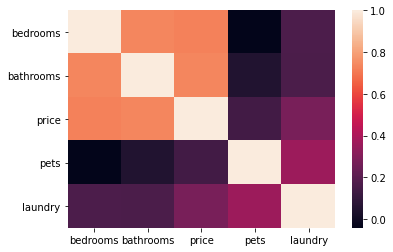

In [20]:
cl.generateHeatmap(areaTable,['neighborhood','bedrooms','bathrooms','price','pets','laundry'])

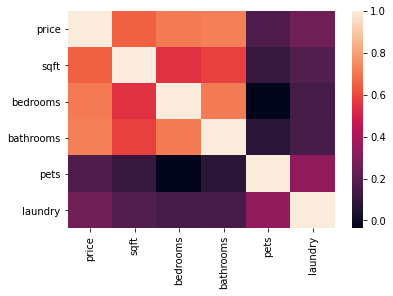

In [21]:
cl.generateHeatmap(tf,['price','sqft','bedrooms','bathrooms','pets','laundry'])

__Finally, let's save our work__

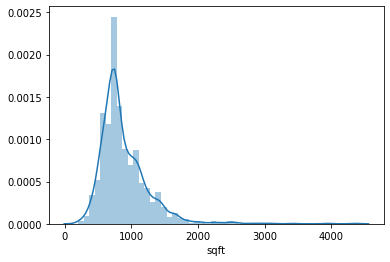

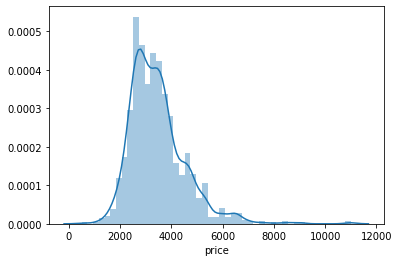

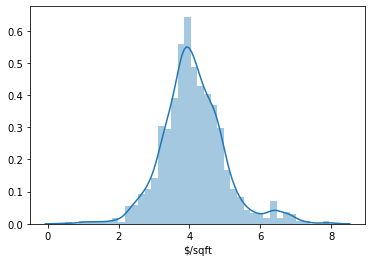

<Figure size 432x288 with 0 Axes>

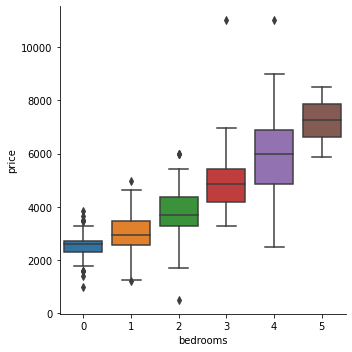

<Figure size 432x288 with 0 Axes>

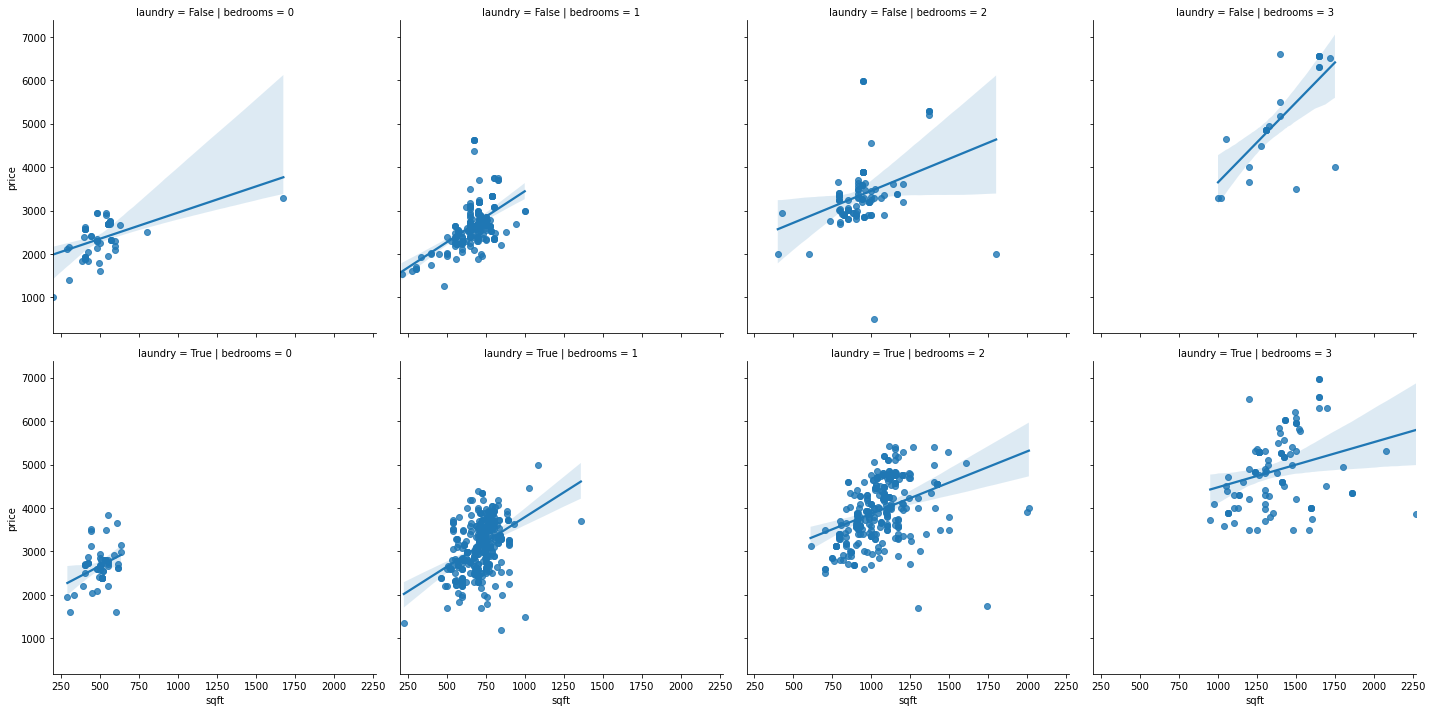

In [22]:
fig1=sns.distplot(areaTable.sqft)
plt.figure()
fig2=sns.distplot(areaTable.price)
plt.figure()
fig4=sns.distplot(areaTable['$/sqft'])
plt.figure()
fig3=sns.catplot(kind='box',x='bedrooms',y='price',data=areaTable)
plt.figure()
outliersIndex = areaTable[areaTable['sqft']>2500].index
areaTable=areaTable.drop(outliersIndex)
reg=sns.lmplot(x='sqft',y='price',row='laundry',col='bedrooms',data=areaTable[areaTable['bedrooms']<4])

In [23]:
from scipy import stats

In [24]:
# get coeffs of linear fit by presence of absence of laundry
pslope1, pets_intercept1, petsr_value1, p_value1,std_err1 = stats.linregress(areaTable[areaTable['pets']==1].sqft,areaTable[areaTable['pets']==1].price)
pslope0, pets_intercept0, petsr_value0, p_value0,std_err0 = stats.linregress(areaTable[areaTable['pets']==0].sqft,areaTable[areaTable['pets']==0].price)
lslope1, laundry_intercept1, laundryr_value1, p_value1,std_err1 = stats.linregress(areaTable[areaTable['laundry']==1].sqft,areaTable[areaTable['laundry']==1].price)
lslope0, laundry_intercept0, laundryr_value0, p_value0,std_err0 = stats.linregress(areaTable[areaTable['laundry']==0].sqft,areaTable[areaTable['laundry']==0].price)


In [25]:
print("Apartments with pets allowed: ",end='')
print("price = ",pslope1,"* (sqft) +",pets_intercept1,"\nr =",petsr_value1,"r2 =",petsr_value1**2)
print("Apartments without pets allowed: ",end='')
print("price = ",pslope0,"* (sqft) +",pets_intercept0,"\nr =",petsr_value0,"r2 =",petsr_value0**2)
print("Apartments with laundry inside: ",end='')
print("price = ",lslope1,"* (sqft) +",laundry_intercept1,"\nr =",laundryr_value1,"r2 =",laundryr_value1**2)
print("Apartments without laundry inside: ",end='')
print("price = ",lslope0,"* (sqft) +",laundry_intercept0,"\nr =",laundryr_value0,"r2 =",laundryr_value0**2)

Apartments with pets allowed: price =  2.5029941727559226 * (sqft) + 1392.3694659522312 
r = 0.7777746766465065 r2 = 0.6049334476325777
Apartments without pets allowed: price =  2.340622849006045 * (sqft) + 1196.8262372740865 
r = 0.7885510822411707 r2 = 0.6218128093037215
Apartments with laundry inside: price =  2.2468937930851096 * (sqft) + 1578.415244126425 
r = 0.753105284929137 r2 = 0.5671675701881966
Apartments without laundry inside: price =  2.6441446783613003 * (sqft) + 947.5672980393358 
r = 0.7873878535703263 r2 = 0.6199796319500855


__We see laundry and/or pets allowed in the apartment offers similar pricing per square foot, but with an increase in the intercept on the price axis.__

### __We can interpret that as a flat increase in the rent for these features__ 

__Let's quantify it:__

In [26]:
print("Allowing pets in the unit or building adds $%.2f to your rent each month" % float(pets_intercept1-pets_intercept0))
print("Allowing laundry in the unit or building adds $%.2f to your rent each month" % float(laundry_intercept1-laundry_intercept0))
laundryValue = laundry_intercept1 - laundry_intercept0
petsValue = pets_intercept1 = pets_intercept0

Allowing pets in the unit or building adds $195.54 to your rent each month
Allowing laundry in the unit or building adds $630.85 to your rent each month


In [27]:
import statsmodels.api as sm
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
areaNumbers = areaTable.loc[:,['bedrooms','bathrooms','sqft','pets','laundry','price']]
np_scaled = min_max_scaler.fit_transform(areaNumbers)
areaTable_normalized = pd.DataFrame(np_scaled,columns=areaNumbers.columns)
X=np.array(areaTable_normalized[['bedrooms','bathrooms','sqft','pets','laundry']], dtype=float)
y=np.array(areaTable_normalized['price'],dtype=float)
model=sm.OLS(y,X).fit()
predictions=model.predict(X)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              4561.
Date:                Sat, 14 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:08:37   Log-Likelihood:                          1273.8
No. Observations:                1265   AIC:                                     -2538.
Df Residuals:                    1260   BIC:                                     -2512.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1647      0.028      5.841      0.000       0.109       0.220
x2            -0.0861      0.020     -4.336      0.000      -0.125      -0.047
x3             0.7916      0.032     24.419      0.000       0.728       0.855
x4             0.0659      0.005     12.547      0.000       0.056       0.076
x5             0.0518      0.006      8.898      0.000       0.040       0.063
==============================================================================
Omnibus:                      258.786   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1565.438
Skew:                          -0.802   Prob(JB):                         0.00
Kurtosis:                       8.208   Cond. No.                         18.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
predictions=predictions*(areaTable.price.max()-areaTable.price.min())

In [29]:
areaTable['predicted'] = predictions

In [30]:
print(areaTable)

                   pid  \
7091649847  7091649847   
7091643626  7091643626   
7091648589  7091648589   
7091647413  7091647413   
7091646440  7091646440   
...                ...   
7093335820  7093335820   
7093335208  7093335208   
7093334725  7093334725   
7075653821  7075653821   
7085927094  7085927094   

                                                                                                       url  \
7091649847      https://sfbay.craigslist.org/pen/apa/d/mountain-view-2br-park-nature-trail/7091649847.html   
7091643626         https://sfbay.craigslist.org/pen/apa/d/daly-city-updated-condo-close-to/7091643626.html   
7091648589   https://sfbay.craigslist.org/pen/apa/d/san-mateo-3-bedroom-3-bath-condo-style/7091648589.html   
7091647413  https://sfbay.craigslist.org/pen/apa/d/san-mateo-spacious-1st-floor-1bed-1bath/7091647413.html   
7091646440      https://sfbay.craigslist.org/pen/apa/d/san-mateo-newly-renovated-1st-floor/7091646440.html   
...                        

In [31]:
areaTable['pred_error'] = areaTable.apply(lambda x : x.price-x.predicted,axis=1)

In [32]:
areaTable.sort_values(by=['pred_error'],ascending=False)

,pid,url,bedrooms,bathrooms,laundry,pets,neighborhood,price,sqft,$/sqft,predicted,pred_error
7092065089,7092065089,https://sfbay.craigslist.org/pen/apa/d/palo-alto-2x2-balcony-pool-clubhouse-in/7092065089.html,2,2,False,False,Palo Alto,5975,945,6.322751,2391.175102,3583.824898
7092767159,7092767159,https://sfbay.craigslist.org/pen/apa/d/palo-alto-2x2-fine-dining-parks-museum/7092767159.html,2,2,False,False,Palo Alto,5975,945,6.322751,2391.175102,3583.824898
7092197498,7092197498,https://sfbay.craigslist.org/pen/apa/d/palo-alto-2x2-large-balcony-overlooking/7092197498.html,2,2,False,False,Palo Alto,5975,945,6.322751,2391.175102,3583.824898
7088624776,7088624776,https://sfbay.craigslist.org/pen/apa/d/menlo-park-charming-home-in-central/7088624776.html,4,3,True,True,Menlo Park,8500,1570,5.414013,5385.626690,3114.373310
7092721431,7092721431,https://sfbay.craigslist.org/pen/apa/d/palo-alto-1x1-garden-terrace-balcony-in/7092721431.html,1,1,False,False,Palo Alto,4625,675,6.851852,1598.364302,3026.635698
...,...,...,...,...,...,...,...,...,...,...,...,...
7090636666,7090636666,https://sfbay.craigslist.org/pen/apa/d/millbrae-very-nice-2-bedroom-house-for/7090636666.html,2,1,True,True,San Bruno,3900,2000,1.950000,6526.712545,-2626.712545
7091500628,7091500628,https://sfbay.craigslist.org/pen/apa/d/el-cajon-home-2-bedrooms-small-pets/7091500628.html,2,1,False,True,Daly City,510,1015,0.502463,3343.932671,-2833.932671
7093389470,7093389470,https://sfbay.craigslist.org/pen/apa/d/redwood-city-enjoy-enjoy-dip-in-our/7093389470.html,2,1,True,True,Redwood City,1690,1300,1.300000,4558.985515,-2868.985515
7090592691,7090592691,https://sfbay.craigslist.org/pen/apa/d/daly-city-extremely-affordable-st/7090592691.html,2,1,False,False,Daly City,2000,1800,1.111111,5023.903703,-3023.903703


__Well, that's it!  We have now assessed all the craigslist posts according to our multivariate model and the final column represents the error (actual price - predicted price).  Listings where `pred_error < 0` are "good deals".  Posts where `pred_error` is two standard deviations or greater (e.g. `< -2000`) are likely to be scam posts.__

In [33]:
gl.saveDataFrame(tf,fileName='cleandata.h5')
gl.saveDataFrame(areaTable,fileName='cleanarea.h5')
tf.to_csv('cleandata_debug.csv')
areaTable.to_csv('cleanarea_debug.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['date', 'neighborhood', 'title', 'url', 'attributes', 'latitude',
       'longitude'],
      dtype='object')]

  """Entry point for launching an IPython kernel.
